# Package Installs

In [ ]:
# !pip install wandb

In [ ]:
# !pip install ensemble_boxes

# Imports

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import os
import numpy as np
import shutil
import ast
from sklearn import model_selection
from tqdm import tqdm
import wandb
from sklearn.model_selection import GroupKFold, StratifiedKFold
from IPython.display import Image, clear_output  
from os import listdir
from os.path import isfile
from glob import glob
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import cv2
from ensemble_boxes import *
from PIL import Image
from PIL import ImageFilter
from os import listdir
from os.path import isfile, join
from pathlib import Path
from pydicom import dcmread

# train.csv file

In [2]:
train_aug = pd.read_csv('train.csv')
train_aug

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


# Add other useful info from DICOM files

In [3]:
from pathlib import Path
from pydicom import dcmread

def add_image_dimensions_gender(df):
    path_spec = "train/{}.dicom"
    height = []
    width = []
    gender = []
    age = []
    for _, row in df.iterrows():
        dcm = dcmread(Path(path_spec.format(row["image_id"])), stop_before_pixels=True)
        height.append(dcm.Rows)
        width.append(dcm.Columns)
        gender.append(dcm[0x10, 0x40].value)
        patient_age = dcm[0x10, 0x1010].value if [0x10, 0x1010] in dcm else ""
        age.append(patient_age)
    df["image_height"] = height
    df["image_width"] = width
    df["gender"] = gender
    df["age"] = age

In [4]:
add_image_dimensions_gender(train_aug)
train_aug

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_height,image_width,gender,age
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,M,
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,,
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,F,061Y
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2880,2304,F,
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,3072,2540,F,022Y
...,...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,3200,2444,,
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,2430,1994,O,
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2500,2048,O,
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,2040,1968,F,052Y


In [5]:
train_aug = train_aug[train_aug.class_id!=14].reset_index(drop = True)

In [6]:
# Change path to the train folder
train_aug['image_path'] = f'jpg_train/'+train_aug.image_id+'.jpg'
plt_test =train_aug.loc[0, 'image_path']
plt_test

'jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg'

In [7]:
type(plt_test)

str

In [8]:
import cv2
from matplotlib import pyplot as plt

In [9]:
path = f'jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg'

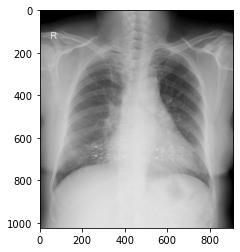

In [10]:
image= cv2.imread(path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(gray)
plt.show()

# Weighted Box Fusion

In [11]:
#https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/208468

# ===============================
# Default WBF config 
iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.1

mapping = {0:'Aortic enlargement', 4:'Consolidation',13:'Pulmonary fibrosis',3:'Cardiomegaly',
           7:'Lung Opacity', 6:'Infiltration',2:'Calcification',1:'Atelectasis',9:'Other lesion',12:'Pneumothorax',
           8:'Nodule/Mass',10:'Pleural effusion',5:'ILD',11:'Pleural thickening'}

# Loading the train DF

df = train_aug
df.fillna(0, inplace=True)
df.loc[df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

results = []
image_ids = df["image_id"].unique()

for image_id in tqdm(image_ids, total=len(image_ids)):
    #print(image_id)
    # All annotations for the current image.
    data = df[df["image_id"] == image_id]
    data = data.reset_index(drop=True)
    annotations = {}
    weights = []
    
    
    width=data.iloc[0].image_width
    height=data.iloc[0].image_height
    image_path=data.iloc[0].image_path
    #class_name=data.iloc[0].class_name

    # WBF expects the coordinates in 0-1 range.
    max_value = data.iloc[:, 4:8].values.max()
    data.loc[:, ["x_min", "y_min", "x_max", "y_max"]] = data.iloc[:, 4:8] / max_value

    # Loop through all of the annotations
    for idx, row in data.iterrows():
        #print(row)

        rad_id = row["rad_id"]
        
        #print(class_name)
        if rad_id not in annotations:
            annotations[rad_id] = {
                "boxes_list": [],
                "scores_list": [],
                "labels_list": [],
            }

            # We consider all of the radiologists as equal.
            weights.append(1.0)

        annotations[rad_id]["boxes_list"].append([row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        annotations[rad_id]["scores_list"].append(1.0)
        annotations[rad_id]["labels_list"].append(row["class_id"])

    boxes_list = []
    scores_list = []
    labels_list = []

    for annotator in annotations.keys():
        boxes_list.append(annotations[annotator]["boxes_list"])
        scores_list.append(annotations[annotator]["scores_list"])
        labels_list.append(annotations[annotator]["labels_list"])

    # Calculate WBF
    boxes, scores, labels = weighted_boxes_fusion(
        boxes_list,
        scores_list,
        labels_list,
        weights=weights,
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr
    )

    for idx, box in enumerate(boxes):
        class_name=row["class_name"]
        results.append({
            "image_id": image_id,
            "class_id": int(labels[idx]),
            "rad_id": "wbf",
            "x_min": box[0] * max_value,
            "y_min": box[1] * max_value,
            "x_max": box[2] * max_value,
            "y_max": box[3] * max_value,
            "width": width,
            "height": height,
            "image_path": image_path,
            "class_name": mapping[int(labels[idx])]
        })

results = pd.DataFrame(results)

  0%|          | 0/4394 [00:00<?, ?it/s]

In [12]:
results.shape

(23904, 11)

In [13]:
results.head()

,image_id,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,class_name
0,9a5094b2563a1ef3ff50dc5c7ff71345,3,wbf,690.666676,1354.333235,1658.666714,1797.666677,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Cardiomegaly
1,9a5094b2563a1ef3ff50dc5c7ff71345,0,wbf,1052.000000,715.000000,1299.000000,966.000000,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Aortic enlargement
2,9a5094b2563a1ef3ff50dc5c7ff71345,11,wbf,1789.000000,1729.000000,1875.000000,1992.000000,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Pleural thickening
3,9a5094b2563a1ef3ff50dc5c7ff71345,10,wbf,1789.000000,1729.000000,1875.000000,1992.000000,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Pleural effusion
4,051132a778e61a86eb147c7c6f564dfe,3,wbf,953.999977,1304.999961,2043.666679,1672.999894,2304,2880,jpg_train/051132a778e61a86eb147c7c6f564dfe.jpg,Cardiomegaly


In [14]:
train_df=results

In [15]:
type(train_df['image_path'][0])

str

# Normalize the data

In [16]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

,image_id,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,class_name,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,3,wbf,0.332051,0.579766,0.797436,0.769549,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Cardiomegaly,0.564744,0.674658,0.465385,0.189783,0.088322
1,9a5094b2563a1ef3ff50dc5c7ff71345,0,wbf,0.505769,0.306079,0.624519,0.413527,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Aortic enlargement,0.565144,0.359803,0.118750,0.107449,0.012760
2,9a5094b2563a1ef3ff50dc5c7ff71345,11,wbf,0.860096,0.740154,0.901442,0.852740,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Pleural thickening,0.880769,0.796447,0.041346,0.112586,0.004655
3,9a5094b2563a1ef3ff50dc5c7ff71345,10,wbf,0.860096,0.740154,0.901442,0.852740,2080,2336,jpg_train/9a5094b2563a1ef3ff50dc5c7ff71345.jpg,Pleural effusion,0.880769,0.796447,0.041346,0.112586,0.004655
4,051132a778e61a86eb147c7c6f564dfe,3,wbf,0.414062,0.453125,0.887008,0.580903,2304,2880,jpg_train/051132a778e61a86eb147c7c6f564dfe.jpg,Cardiomegaly,0.650535,0.517014,0.472946,0.127778,0.060432


In [17]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((23904, 9), (23904,))

# labels txt

In [18]:
# os.makedirs(f'labels', exist_ok = True)
labels_dir = 'labels'

In [19]:
label_df = train_df[['image_id','class_id', 'x_mid', 'y_mid', 'w', 'h']]

In [20]:
label_df.head()

,image_id,class_id,x_mid,y_mid,w,h
0,9a5094b2563a1ef3ff50dc5c7ff71345,3,0.564744,0.674658,0.465385,0.189783
1,9a5094b2563a1ef3ff50dc5c7ff71345,0,0.565144,0.359803,0.118750,0.107449
2,9a5094b2563a1ef3ff50dc5c7ff71345,11,0.880769,0.796447,0.041346,0.112586
3,9a5094b2563a1ef3ff50dc5c7ff71345,10,0.880769,0.796447,0.041346,0.112586
4,051132a778e61a86eb147c7c6f564dfe,3,0.650535,0.517014,0.472946,0.127778


In [21]:
type(label_df['x_mid'])

pandas.core.series.Series

In [22]:
label_df['bbox'] = label_df[['class_id', 'x_mid', 'y_mid', 'w', 'h']].values.tolist()

/home/ubuntu/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [23]:
len(pd.unique(label_df['image_id']))

4394

In [24]:
label_df.describe()

,class_id,x_mid,y_mid,w,h
count,23904.000000,23904.000000,23904.000000,23904.000000,23904.000000
mean,7.244436,0.493648,0.439866,0.156606,0.130043
std,4.346152,0.223853,0.195153,0.122105,0.113924
min,0.000000,0.015625,0.022304,0.003906,0.000989
25%,3.000000,0.292111,0.288615,0.070312,0.054329
50%,8.000000,0.546404,0.412595,0.119541,0.104331
75%,11.000000,0.672169,0.593915,0.201172,0.156680
max,13.000000,0.983398,0.979711,0.957212,0.980375


In [25]:
len(label_df)

23904

In [26]:
# # Create txt files for all labels in yolo format and move to labels folder

# for _, row in tqdm(label_df.iterrows()):
#     image_name = row['image_id']
#     bounding_boxes = [row['bbox']]
#     yolo_data = []
#     for bbox in bounding_boxes:
#         category = int(bbox[0])
#         x_center = bbox[1]
#         y_center = bbox[2]
#         w = bbox[3]
#         h = bbox[4]
#         yolo_data_string = str(int(category))+' '+str(x_center)+' '+ str(y_center)+' '+str(w)+' '+str(h)

#     filepath = os.path.join(labels_dir, f'{image_name}.txt')

#     with open(filepath, 'a') as f:
#         f.write(str(yolo_data_string)+ "\n")



# Base Model Train Val Split

In [27]:
# fold=0
# gkf  = GroupKFold(n_splits = 0)
# train_df['fold'] = -1
# for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
#     train_df.loc[val_idx, 'fold'] = fold
# train_df.head()

# Train Val Split K-fold 5

In [28]:
# fold=0
# gkf  = GroupKFold(n_splits = 5)
# train_df['fold'] = -1
# for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
#     train_df.loc[val_idx, 'fold'] = fold
# train_df.head()

In [29]:
train_df.shape

(23904, 16)

In [31]:
# train_df['fold'].unique()

### Run this for each fold

In [32]:
# for i in range(5):
#     fold=i
#     train_files = []
#     val_files   = []
#     val_files += list(train_df[train_df.fold==fold].image_path.unique())
#     train_files += list(train_df[train_df.fold!=fold].image_path.unique())

#     #Create folders for train and validation and the corresponding labels and move them to the right location

#     os.makedirs(f'k-folds/labels/{fold}/train', exist_ok = True)
#     os.makedirs(f'k-folds/labels/{fold}/val', exist_ok = True)
#     os.makedirs(f'k-folds/images/{fold}/train', exist_ok = True)
#     os.makedirs(f'k-folds/images/{fold}/val', exist_ok = True)
#     label_dir = 'labels'
#     image_dir_train = f'k-folds/images/{fold}/train'
#     image_dir_val = f'k-folds/images/{fold}/val'
#     label_dir_train = f'k-folds/labels/{fold}/train'
#     label_dir_val = f'k-folds/labels/{fold}/val'
    
#     for file in tqdm(train_files):
#         try:
#             shutil.copy(file, image_dir_train)
#             filename = file.split('/')[-1].split('.')[0]
#             shutil.copy(os.path.join(labels_dir, filename +'.txt'), label_dir_train)
#         except:
#             print("No such file")

#     for file in tqdm(val_files):
#         try:
#             shutil.copy(file, image_dir_val)
#             filename = file.split('/')[-1].split('.')[0]
#             shutil.copy(os.path.join(label_dir, filename+'.txt'), label_dir_val)
#         except:
#             print("No such file")

# Yolo Hyperparameters

In [33]:
# #cwd = '/content/'
# cwd = '/home/ubuntu/vinbigdata/yolov5/data/hyps'

# # Hyperparameters
# hyp = {'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
#        'lrf': 0.2,  # final OneCycleLR learning rate (lr0 * lrf)
#        'momentum': 0.937,  # SGD momentum
#        'weight_decay': 5e-4,  # optimizer weight decay
#        'warmup_epochs': 3.0,  # warmup epochs (fractions ok)
#        'warmup_momentum': 0.8,  # warmup initial momentum
#        'warmup_bias_lr': 0.1,  # warmup initial bias lr
#        'box': 0.05,  # box loss gain
#        'giou': 0.05,  # giou loss gain
#        'cls': 0.5,  # cls loss gain
#        'cls_pw': 1.0,  # cls BCELoss positive_weight
#        'obj': 1.0,  # obj loss gain (*=img_size/320 if img_size != 320)
#        'obj_pw': 1.0,  # obj BCELoss positive_weight
#        'iou_t': 0.20,  # iou training threshold (TRY LOWERING THIS)
#        'anchor_t': 4.0,  # anchor-multiple threshold
#        'anchors': 3,  # anchors per output layer (0 to ignore)
#        'fl_gamma': 0,  # focal loss gamma (efficientDet default is gamma=1.5)
#        'hsv_h': 0.014,  # image HSV-Hue augmentation (fraction)
#        'hsv_s': 0.68,  # image HSV-Saturation augmentation (fraction)
#        'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
#        'degrees': 0.2,  # image rotation (+/- deg)
#        'translate': 0.2,  # image translation (+/- fraction)
#        'scale': 0.3,  # image scale (+/- gain)
#        'shear': 0.2,  # image shear (+/- deg)
#        'perspective': 0.0,  # image perspective (+/- fraction), range 0-0.001
#        'flipud': 0.0,  # image flip up-down (probability)
#        'fliplr': 0.0,  # image flip left-right (probability)
#        'mosaic': 1.0,  # image mosaic (probability)
#        'mixup': 0.0}  # image mixup (probability)


# with open(join( cwd , 'hyp_new.yaml'), 'w') as outfile:
#     yaml.dump(hyp, outfile, default_flow_style=False)

# f = open(join( cwd , 'hyp_new.yaml'), 'r')
# print('\nyaml:')
# print(f.read())

# Yolo yml file

In [34]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes=list(set(classes))
classes

['Pneumothorax',
 'Lung Opacity',
 'Other lesion',
 'Infiltration',
 'Cardiomegaly',
 'Pleural thickening',
 'Calcification',
 'ILD',
 'Pulmonary fibrosis',
 'Atelectasis',
 'Nodule/Mass',
 'Aortic enlargement',
 'Consolidation',
 'Pleural effusion']

In [35]:
# Ensemble

In [36]:
# # from os import listdir
# # from os.path import isfile, join
# import yaml

# for i in range(5):
#     fold = i
#     cwd = f'/home/ubuntu/vinbigdata/k-folds/images/{fold}/'

#     with open(join( cwd , 'train.txt'), 'w') as f:
#         for path in glob(f'/home/ubuntu/vinbigdata/k-folds/images/{fold}/train/*'):
#             f.write(path+'\n')

#     with open(join( cwd , 'val.txt'), 'w') as f:
#         for path in glob(f'/home/ubuntu/vinbigdata/k-folds/images/{fold}/val/*'):
#             f.write(path+'\n')

#     # with open(join( cwd , 'val.txt'), 'w') as f:
#     #     for path in glob('/home/ubuntu/GitHub/Data/vinbigdata/images/val/*'):
#     #         f.write(path+'\n')

#     with open(join( cwd , 'test.txt'), 'w') as f:
#         for path in glob('/home/ubuntu/vinbigdata/jpg_test/*'):
#             f.write(path+'\n')

#     data = dict(
#         train =  join( cwd , 'train.txt') ,
#         val   =  join( cwd , 'val.txt' ),
#         test =  join( cwd , 'test.txt'),
#         nc    = 14,
#         names = classes
#         )

#     with open(join( cwd , f'vinbigdata_{fold}.yaml'), 'w') as outfile:
#         yaml.dump(data, outfile, default_flow_style=False)

#     f = open(join( cwd , f'vinbigdata_{fold}.yaml'), 'r')
#     print('\nyaml:')
#     print(f.read())

# Training

In [37]:
os.chdir('yolov5')
import torch

In [38]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: insigh1 (use `wandb login --relogin` to force relogin)


True

In [39]:
!nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Mon Dec  6 15:54:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   27C    P0    23W / 300W |      2MiB / 16160MiB |      0%    

In [40]:
!pwd

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/home/ubuntu/vinbigdata/yolov5


In [41]:
# # download weights
# !python detect.py --weights yolov5x.pt

In [42]:
# train test
!python train.py --img 1024 --batch 16 --epochs 3 --data /home/ubuntu/vinbigdata/k-folds/images/0/vinbigdata_0.yaml --cache --cfg ./models/yolov5x.yaml --weights yolov5/data/hyps/hyp_new.yaml

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Traceback (most recent call last):
  File "train.py", line 34, in <module>
    import val  # for end-of-epoch mAP
  File "/home/ubuntu/vinbigdata/yolov5/val.py", line 26, in <module>
    from models.common import DetectMultiBackend
  File "/home/ubuntu/vinbigdata/yolov5/models/common.py", line 23, in <module>
    from utils.datasets import exif_transpose, letterbox
  File "/home/ubuntu/vinbigdata/yolov5/utils/datasets.py", line 28, in <module>
    from utils.augmentations import Albumentations, augment_hsv, copy_paste, letterbox, mixup, random_perspective
  File "/home/ubuntu/vinbigdata/yolov5/utils/augmentations.py", line 12, in <module>
    from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box

In [ ]:
# !conda install pytorch torchvision cudatoolkit=10.2 -c pytorch